In [1]:
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from tqdm import tqdm
from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from torchvision.utils import save_image

In [2]:
# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

#channels of input
channels = 1

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
img_size = 28

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 1e-4

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

#Weight-Clip Value
clip_value = 1e-2

#After every n_critic iters, Generator Trains
n_critic = 10

#Sampling interval
sample_interval = 100

In [3]:
dataset = torchvision.datasets.MNIST(
        "./data/mnist",
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Normalize([0.5], [0.5])]),
    )

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers
)

In [4]:
img_shape = (channels, img_size, img_size)

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(nz, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *img_shape)
        return img


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
        )

    def forward(self, img):
        img_flat = img.view(img.shape[0], -1)
        validity = self.model(img_flat)
        return validity


# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

if ngpu>0:
    generator.cuda()
    discriminator.cuda()
    
# generator = nn.DataParallel(generator)
# discriminator = nn.DataParallel(discriminator)

In [5]:
# Optimizers
optimizer_G = torch.optim.RMSprop(generator.parameters(), lr=lr)
optimizer_D = torch.optim.RMSprop(discriminator.parameters(), lr=lr)

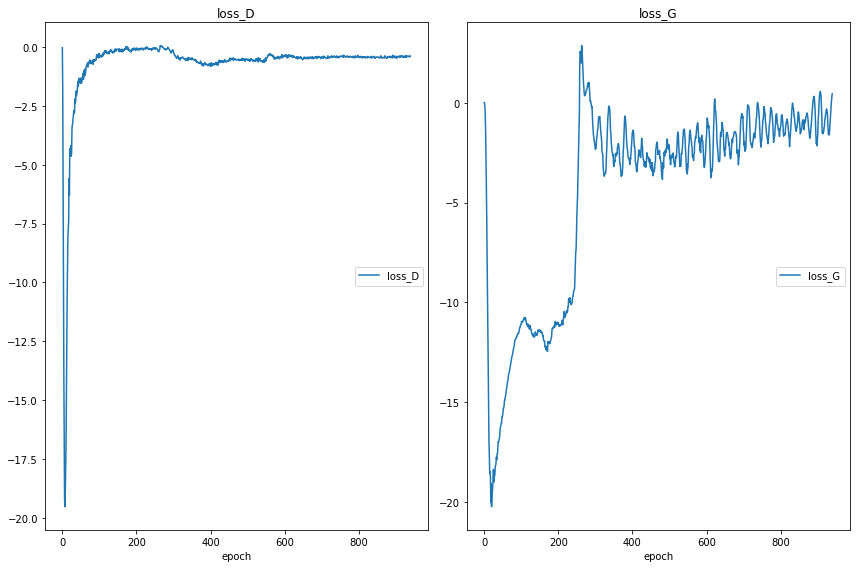

loss_D
	loss_D           	 (min:  -19.531, max:    0.066, cur:   -0.384)
loss_G
	loss_G           	 (min:  -20.232, max:    2.871, cur:    0.454)


In [6]:
batches_done = 0
fixed_noise = torch.randn(size=(32, nz)).cuda()
liveloss = PlotLosses()
logs={}
img_list = []
for epoch in range(num_epochs):

    for i, (real_imgs, _) in enumerate(dataloader):

        # ---------------------
        #  Train Discriminator
        # ---------------------
        real_imgs = real_imgs.cuda()
        optimizer_D.zero_grad()

        # Sample noise as generator input
        z = torch.randn(size=(real_imgs.shape[0], nz)).cuda()

        # Generate a batch of images
        fake_imgs = generator(z).detach()
        # Adversarial loss
        loss_D = torch.mean(discriminator(real_imgs)) - torch.mean(discriminator(fake_imgs))

        loss_D.backward()
        optimizer_D.step()

        # Clip weights of discriminator
        for p in discriminator.parameters():
            p.data.clamp_(-clip_value, clip_value)

        # Train the generator every n_critic iterations
        if i % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            # Generate a batch of images
            gen_imgs = generator(z)
            # Adversarial loss
            loss_G = torch.mean(discriminator(gen_imgs))

            loss_G.backward()
            optimizer_G.step()

            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, num_epochs, batches_done % len(dataloader), len(dataloader), loss_D.item(), loss_G.item())
            )
            logs['loss_D'] = loss_D.item()
            logs['loss_G'] = loss_G.item()
            liveloss.update(logs)
            liveloss.send()

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            grid = torchvision.utils.make_grid(fake, padding=2, normalize=True)
            img_list.append(grid)
            plt.figure(figsize=(8,8))
            plt.axis("off")
            plt.title("Fixed Noise Images")
            plt.imshow(np.transpose(grid.cpu(),(1,2,0)))
#             save_image(gen_imgs.data[:25], "images/%d.png" % batches_done, nrow=5, normalize=True)
            
            plt.show()
        batches_done += 1
        

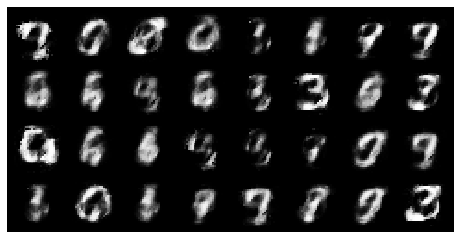

In [7]:
#%%capture
fig = plt.figure(figsize=(8,5))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
ani.save('./gifs/animation_3_ncritic_10.gif', writer='imagemagick', fps=30)
HTML(ani.to_jshtml())